<h1>
<hr style=" border:none; height:3px;">
<center>Computer Vision - Photo to Chess Board Project</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Paul-Alexandre MARENGHI</center></h4>

# 0 - Import

https://github.com/shainisan/real-life-chess-vision
<div class='alert alert-block alert-success'> <strong>PLAN</strong> <br>
- Read Img<br>
- Detect Corners<br>
- Perspective Transformation + calculate square positions<br>
- Detect pieces on board<br>
- TADA!<br>
</div>


In [3]:
from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from PIL import Image
import cv2
from shapely.geometry import Polygon, box

# I - Detect Corners

## I.1 - Detection of corner

In [46]:
def segment_chessboard(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # You might need to tweak these ranges depending on the board color
    lower_color = np.array([0, 30, 30])
    upper_color = np.array([180, 255, 200])

    mask = cv2.inRange(hsv, lower_color, upper_color)
    result = cv2.bitwise_and(image, image, mask=mask)

    return result, mask

def detect_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            return approx.reshape(4, 2)
    return None


def show_image_rgb(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

## I.2 - Perspective

In [62]:
def warp_perspective(image, corners):
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    
    image = np.array(image)

    rect = order_points(np.array(corners, dtype="float32"))
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped


def divide_board_into_grid(image, grid_size=8):
    import numpy as np
    h, w = image.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size
    grid = []
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            y1, y2 = i * cell_h, (i + 1) * cell_h
            x1, x2 = j * cell_w, (j + 1) * cell_w
            cell = image[y1:y2, x1:x2]
            row.append(cell)
        grid.append(row)
    return grid


## I.3 - Adding cells

# II - Detection

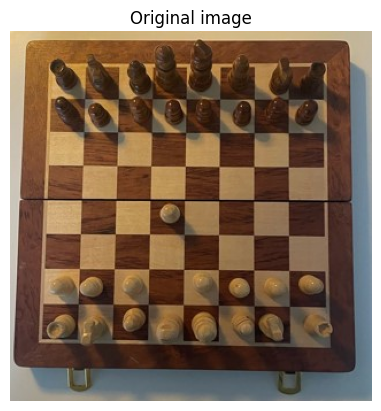

data/chessboard/chessboard.jpg


In [ ]:
image = 'data/chessboard/chessboard.jpg'
img = cv2.imread(image)
show_image_rgb(img, "Original image")

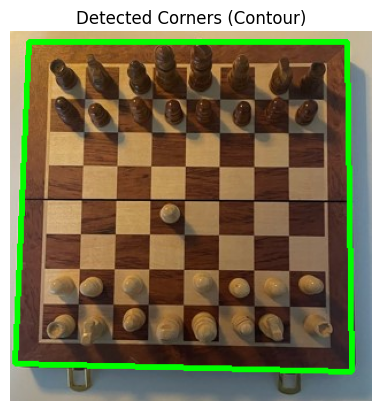

In [65]:
corners = detect_corners(img)
cv2.polylines(img, [np.int32(corners)], isClosed=True, color=(0, 255, 0), thickness=3)
show_image_rgb(img, "Detected Corners (Contour)")

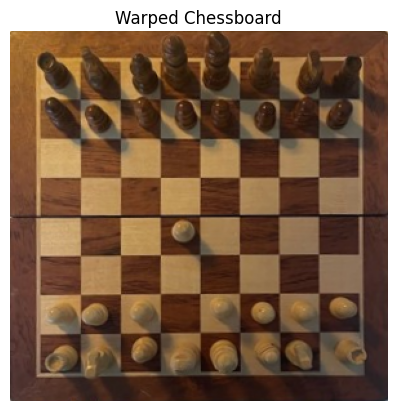

In [69]:
warped = warp_perspective(img, corners)
show_image_rgb(warped, "Warped Chessboard")